In [1]:
import pandas as pd
import numpy as np
from utilities import *
from crossValidation import *
from features import *
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [2]:
# Data
df_ohlcv = pd.read_csv('Analysis/data/full_5m_futures/XRPUSDT_futures_5m_202001_202404.csv', index_col=0)
# df_ohlcv = pd.read_csv('data/full_5m_futures/1000SHIBUSDT_futures_5m_202105_202401.csv', index_col=0)
# df_ohlcv = pd.read_csv('data/alt_bars/XRPUSDT_dollar.csv', index_col=0)
df_ohlcv['barID'] = df_ohlcv.reset_index().index.values
df_ohlcv.set_index('Time', inplace=True)
df_ohlcv.index = pd.to_datetime(df_ohlcv.index, unit='ms')

In [3]:
trainStart, trainEnd = pd.to_datetime("2021-01-01"), pd.to_datetime("2022-12-15"); trainDays = (trainEnd - trainStart).days
testStart, testEnd = pd.to_datetime("2023-01-01"), pd.to_datetime("2024-04-30"); testDays = (testEnd - testStart).days

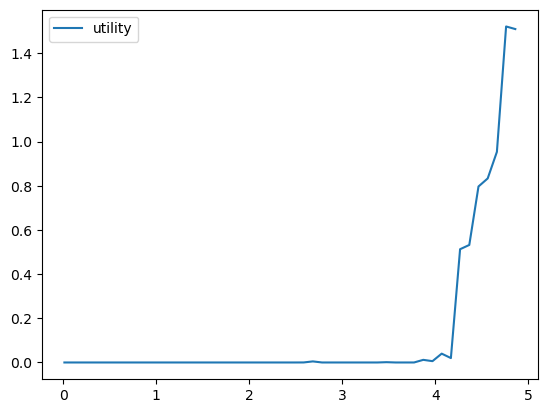

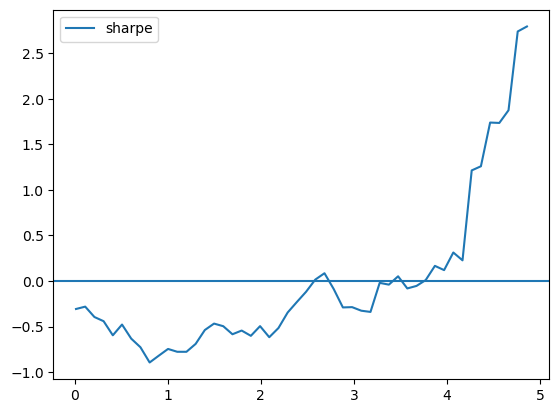

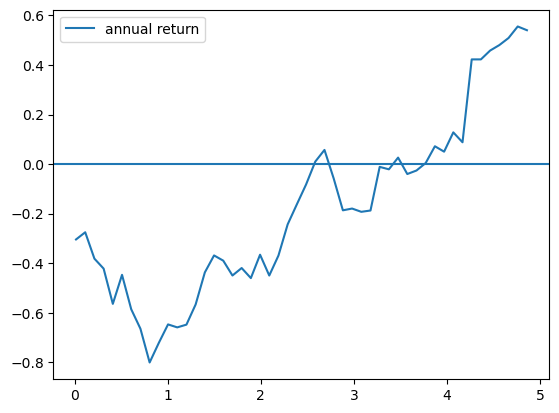

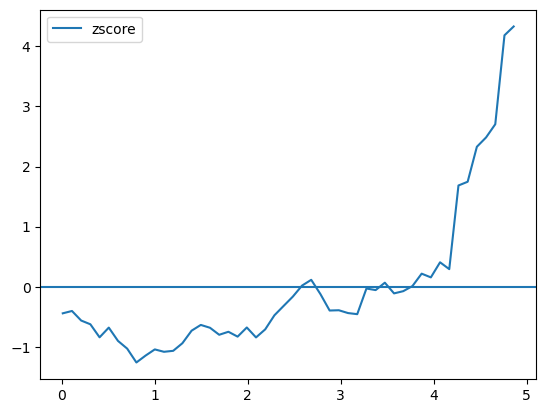

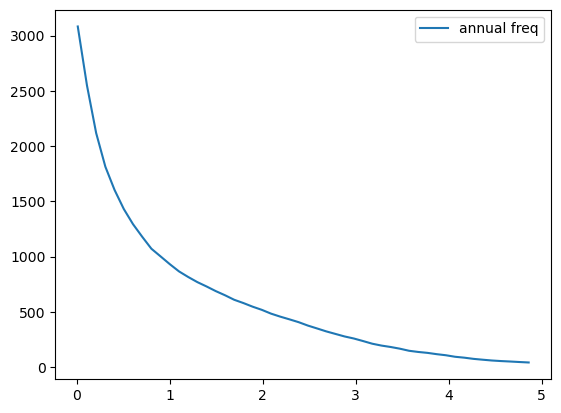

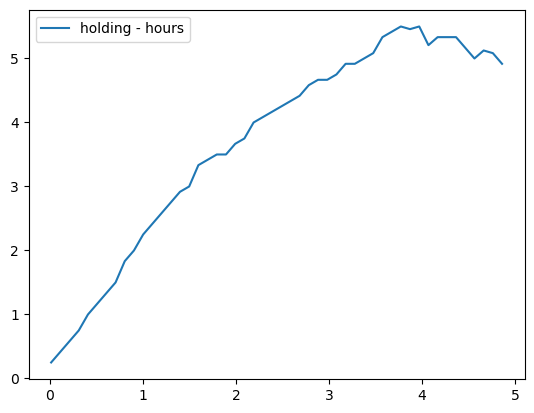

In [6]:
# Bollinger Sampling
lookback = 100
feat = getBollinger(df_ohlcv.Close, lookback)
# entry_quantiles = feat.mean() + feat.std()*np.linspace(-3.5,0,50)
entry_quantiles = feat.mean() + feat.std()*np.linspace(0,3.5,50)

# side='long'
side='short'
tradingDays = 365
dataDays = trainDays

getFeatUtility_dynamicExit (feat[trainStart:trainEnd], side, entry_quantiles,'downward', 0, 'upward', df_ohlcv, dataDays, 365, 1, 0.0001, mid = 0, visual = True)        
# getFeatUtility_dynamicExit (feat[trainStart:trainEnd], side, entry_quantiles,'upward', 0, 'downward', df_ohlcv, dataDays, 365, 1, 0.0001, mid = 0, visual = True)        

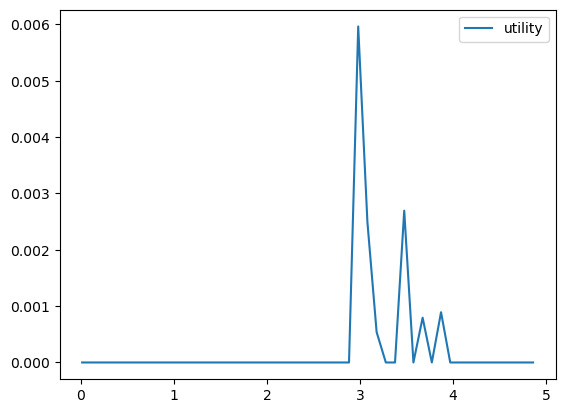

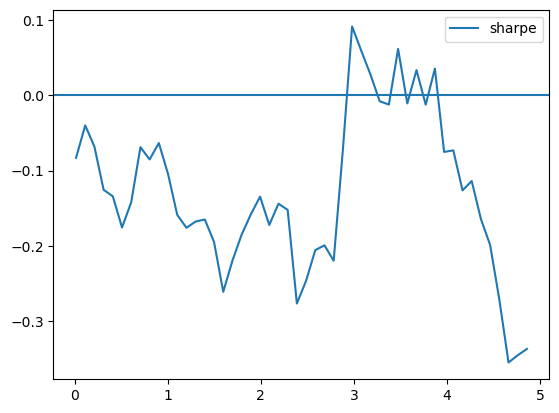

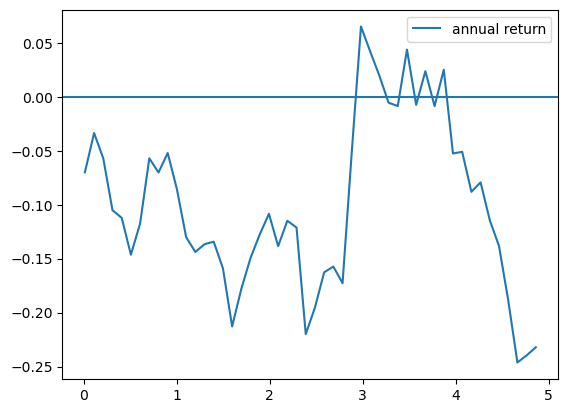

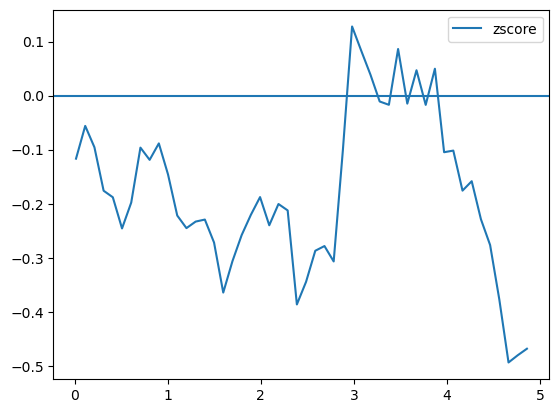

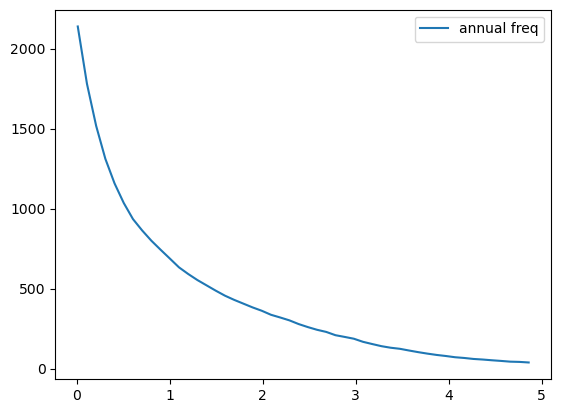

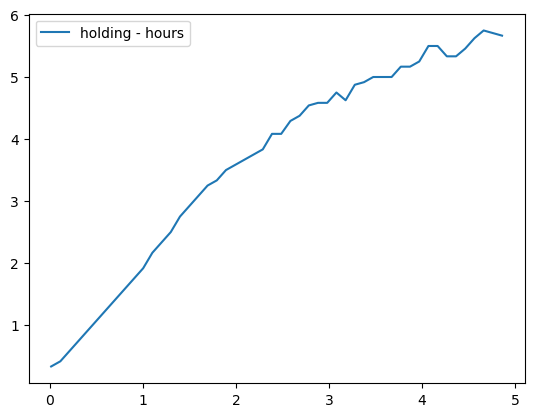

In [7]:
getFeatUtility_dynamicExit (feat[testStart:testEnd], side, entry_quantiles,'downward', 0, 'upward', df_ohlcv, dataDays, 365, 1, 0.0001, mid = 0, visual = True)       
# getFeatUtility_dynamicExit (feat[testStart:testEnd], side, entry_quantiles,'upward', 0, 'downward', df_ohlcv, dataDays, 365, 1, 0.0001, mid = 0, visual = True)         

### Filter Variable Search

In [7]:
events = getCrossingEvents_dynamicExit(feat, df_ohlcv, -2.75, 0, 'downward', 'upward', 0)
ret = get_lrets(events, df_ohlcv, commission = 0.001, betSize = 1)
Y = pd.DataFrame(index =ret.index)
Y['ret'] = ret
Y['bin'] = (ret>0).astype(int)

In [8]:
# Feature Library
# 13개
def add_featureSetA (X, tEvent, df, scale, lookback):
    print(f'Adding Feature Set A with lookback={lookback} and scale = {scale}')
    close_path = getPathMatrix(df.Close, tEvent, nbars = lookback, scale = scale)
    lrets_path = np.log(close_path).diff(axis=1)
    
    X[f'sharpe1_{scale}'] = (lrets_path.sum(axis=1)/np.sqrt((lrets_path**2).sum(axis=1)))
    X[f'sharpe2_{scale}'] = (lrets_path.sum(axis=1)/lrets_path.std(axis=1))
    X[f'returns_{scale}'] = lrets_path.sum(axis=1)
    X[f'std_{scale}'] = lrets_path.std(axis=1)
    X[f'vol_{scale}'] = np.sqrt((lrets_path**2).sum(axis=1))

    X[f'blgr_{scale}'] = getBollinger(df.Close, lookback*scale)[tEvent]
    X[f'trend_{scale}'] = getTrend(tEvent, df.Close, lookback, scale = scale, use_log=True)
    X[f'trendblgr_{scale}'] = getTrendBlgr(tEvent, df.Close, lookback, scale = scale, use_log=True)
    X[f'willR_{scale}'] = williamsR(df.Close, lookback*scale, nFrac=10)[tEvent]

    X[f'ar1_{scale}'] = getAR1(tEvent, df.Close, lookback, scale=scale, use_log=True)
    X[f'adf_{scale}'] = getADF(tEvent, df.Close, lookback, scale=scale,  constant ='c', lags = int(lookback*0.1),)                      

    X[f'macd_norm1_{scale}'] = getMACD_norm(df.Close, span_short = scale*lookback//4, span_long = scale*lookback//2, use_ewm = False)[tEvent]
    X[f'macd_norm2_{scale}'] = getMACD_norm(df.Close, span_short = scale*lookback//2, span_long = scale*lookback, use_ewm = False)[tEvent]
    return X

# 총 30개
def add_featureSetB(X, tEvent, df, scale, lookback):
    print(f'Adding Feature Set B with lookback={lookback} and scale = {scale}')
    import ta
    lookback = lookback*scale
    
    # # Volume (2)
    X[f'cmf_{scale}'] = ta.volume.ChaikinMoneyFlowIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=lookback).chaikin_money_flow().loc[tEvent]
    X[f'mfi_{scale}'] = ta.volume.MFIIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=lookback).money_flow_index().loc[tEvent]

    # Volatility Indicators (6)
    X[f'bbw_{scale}'] = ta.volatility.BollingerBands(close=df['Close'], window=lookback).bollinger_wband().loc[tEvent]
    X[f'bbp_{scale}'] = ta.volatility.BollingerBands(close=df['Close'], window=lookback).bollinger_pband().loc[tEvent]
    X[f'kcw_{scale}'] = ta.volatility.KeltnerChannel(close=df['Close'], high=df['High'], low=df['Low'], window=lookback).keltner_channel_wband().loc[tEvent]
    X[f'dcw_{scale}'] = ta.volatility.DonchianChannel(high=df['High'], low=df['Low'], close=df['Close'], window=lookback).donchian_channel_wband().loc[tEvent]
    X[f'dcp_{scale}'] = ta.volatility.DonchianChannel(high=df['High'], low=df['Low'], close=df['Close'], window=lookback).donchian_channel_pband().loc[tEvent]
    X[f'ui_{scale}'] = ta.volatility.UlcerIndex(close=df['Close'], window=lookback).ulcer_index().loc[tEvent]

    # Trend Indicators (12)
    X[f'vortex_ind_diff_{scale}'] = ta.trend.VortexIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=lookback).vortex_indicator_diff().loc[tEvent]
    X[f'trix_{scale}'] = ta.trend.TRIXIndicator(close=df['Close'], window=lookback).trix().loc[tEvent]
    X[f'kst_{scale}'] = ta.trend.KSTIndicator(close=df['Close'], window1=lookback, window2=lookback*2, window3=lookback*3, window4=lookback*4).kst().loc[tEvent]
    X[f'kst_sig_{scale}'] = ta.trend.KSTIndicator(close=df['Close'], window1=lookback, window2=lookback*2, window3=lookback*3, window4=lookback*4).kst_sig().loc[tEvent]
    X[f'kst_diff_{scale}'] = ta.trend.KSTIndicator(close=df['Close'], window1=lookback, window2=lookback*2, window3=lookback*3, window4=lookback*4).kst_diff().loc[tEvent]
    X[f'stc_{scale}'] = ta.trend.STCIndicator(close=df['Close'], window_slow=lookback, window_fast=lookback//2).stc().loc[tEvent]
    X[f'adx_{scale}'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=lookback).adx().loc[tEvent]
    X[f'adx_pos_{scale}'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=lookback).adx_pos().loc[tEvent]
    X[f'adx_neg_{scale}'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=lookback).adx_neg().loc[tEvent]
    X[f'aroon_up_{scale}'] = ta.trend.AroonIndicator(high=df['High'], low=df['Low'], window=lookback).aroon_up().loc[tEvent]
    X[f'aroon_down_{scale}'] = ta.trend.AroonIndicator(high=df['High'], low=df['Low'], window=lookback).aroon_down().loc[tEvent]
    X[f'aroon_ind_{scale}'] = ta.trend.AroonIndicator(high=df['High'], low=df['Low'], window=lookback).aroon_indicator().loc[tEvent]

    # Momentum Indicators (10)
    X[f'stoch_rsi_{scale}'] = ta.momentum.StochRSIIndicator(close=df['Close'], window=lookback).stochrsi().loc[tEvent]
    X[f'stoch_rsi_k_{scale}'] = ta.momentum.StochRSIIndicator(close=df['Close'], window=lookback).stochrsi_k().loc[tEvent]
    X[f'stoch_rsi_d_{scale}'] = ta.momentum.StochRSIIndicator(close=df['Close'], window=lookback).stochrsi_d().loc[tEvent]
    X[f'tsi_{scale}'] = ta.momentum.TSIIndicator(close=df['Close'], window_slow=lookback, window_fast=lookback//2).tsi().loc[tEvent]
    X[f'uo_{scale}'] = ta.momentum.UltimateOscillator(high=df['High'], low=df['Low'], close=df['Close'], window1=lookback, window2=lookback*2, window3=lookback*3).ultimate_oscillator().loc[tEvent]
    X[f'stoch_{scale}'] = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=lookback).stoch().loc[tEvent]
    X[f'stoch_sig_{scale}'] = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=lookback).stoch_signal().loc[tEvent]
    X[f'wr_{scale}'] = ta.momentum.WilliamsRIndicator(high=df['High'], low=df['Low'], close=df['Close'], lbp=lookback).williams_r().loc[tEvent]
    X[f'ppo_{scale}'] = ta.momentum.PercentagePriceOscillator(close=df['Close'], window_slow=lookback, window_fast=lookback//2, window_sign = lookback//3).ppo().loc[tEvent]
    X[f'ppo_signal_{scale}'] = ta.momentum.PercentagePriceOscillator(close=df['Close'], window_slow=lookback, window_fast=lookback//2, window_sign = lookback//3).ppo_signal().loc[tEvent]

    return X


In [9]:
# Build Features
X1 = pd.DataFrame(index = Y.index)
X2 = pd.DataFrame(index = Y.index)

df = df_ohlcv
lookback = 100

scale = 1
X1 = add_featureSetA(X1, Y.index, df, scale, lookback)
X2 = add_featureSetB(X2, Y.index, df, scale, lookback)

scale = 4
X1 = add_featureSetA(X1, Y.index, df, scale, lookback)
X2 = add_featureSetB(X2, Y.index, df, scale, lookback)

scale = 10
X1 = add_featureSetA(X1, Y.index, df, scale, lookback)
X2 = add_featureSetB(X2, Y.index, df, scale, lookback)

scale = 40
X1 = add_featureSetA(X1, Y.index, df, scale, lookback)
X2 = add_featureSetB(X2, Y.index, df, scale, lookback)

Adding Feature Set A with lookback=100 and scale = 1
Adding Feature Set B with lookback=100 and scale = 1


KeyboardInterrupt: 

In [18]:
X = pd.concat([X1,X2], axis = 1)
# X = pd.concat([X1], axis = 1)
Y['cont'] = Y['ret'] # Return, Slope, Sharpe
Y['bin'] = (Y['cont']>0).astype(int)
X.shape, Y.shape

((1503, 172), (1503, 3))

In [19]:
X_clean = X.replace([np.inf, -np.inf], np.nan)
X_clean = X_clean.dropna()
intersected_indices = X_clean.index.intersection(Y.index)
Y_clean = Y.loc[intersected_indices]
X_clean = X_clean.loc[intersected_indices]
print(X_clean.shape, Y_clean.shape)

(1453, 172) (1453, 3)


In [43]:
# X_train, X_test, Y_train, Y_test = train_test_split(X_clean, Y_clean, test_size=0.15, shuffle=False)
X_train, X_test, Y_train, Y_test = X_clean.loc[trainStart:trainEnd], X_clean.loc[testStart:testEnd], Y_clean.loc[trainStart:trainEnd], Y_clean.loc[testStart:testEnd]
print('default precision:', Y_test[Y_test['cont']>0]['cont'].sum()/Y_test['cont'].abs().sum())

default precision: 0.5629937597386255


<Axes: xlabel='Time'>

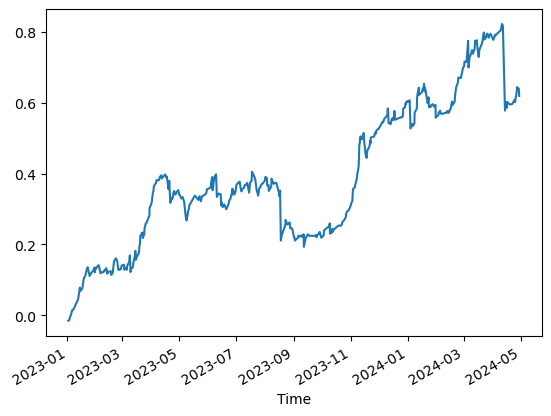

In [44]:
(Y_test.ret).cumsum().plot()

In [45]:
# RF Simple
clf = RandomForestClassifier(n_estimators=500, max_depth = 1, min_samples_leaf = 0.3, max_features=X.shape[1]//3,random_state=2, bootstrap = True, n_jobs=-1,)
clf.fit(X_train, Y_train.bin, sample_weight=Y_train.cont.abs())
y_proba_train = clf.predict_proba(X_train)[:,1]
y_proba_test = clf.predict_proba(X_test)[:,1]

In [78]:
used_features = set()
for tree in clf.estimators_:
    tree_features = tree.tree_.feature
    used_features.update(tree_features[tree_features >= 0])
if isinstance(X_train, pd.DataFrame):
    used_feature_names = [X_train.columns[i] for i in used_features]
else:
    used_feature_names = list(used_features)
X_train_ = X_train.loc[:,used_feature_names]
X_test_ = X_test.loc[:,used_feature_names]
# RF Simple
clf = RandomForestClassifier(n_estimators= 500, max_depth = 1, min_samples_leaf = 0.3, max_features='sqrt',random_state=12, bootstrap = True, n_jobs=-1,)
clf.fit(X_train_, Y_train.bin, sample_weight=Y_train.cont.abs())
y_proba_train = clf.predict_proba(X_train_)[:,1]
y_proba_test = clf.predict_proba(X_test_)[:,1]

In [79]:
X_train_.shape

(687, 47)

In [72]:
# # Save Model
# import pickle
# with open('xrp_model.pkl', 'wb') as f:
#     pickle.dump(clf, f)

In [86]:
# Classification report
y_pred_test = (y_proba_test > 0.5).astype(int)
print("percent of samples:", y_pred_test.sum()/len(y_pred_test)) 
print()
print(classification_report(Y_test['bin'], y_pred_test))#, sample_weight=Y_test['ret'].abs()))

percent of samples: 0.40130151843817785

              precision    recall  f1-score   support

           0       0.33      0.68      0.44       133
           1       0.77      0.43      0.55       328

    accuracy                           0.50       461
   macro avg       0.55      0.55      0.50       461
weighted avg       0.64      0.50      0.52       461



# Backtest

(266,)


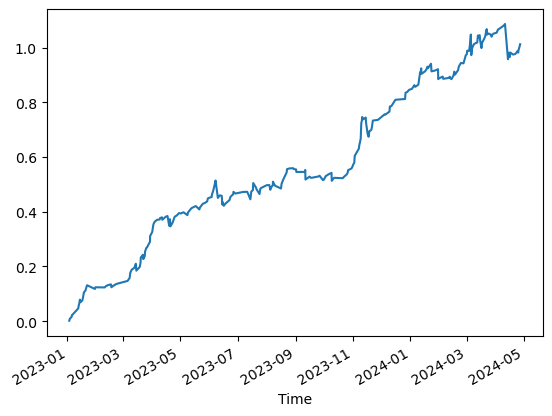

In [94]:
selected = Y_test.ret[y_proba_test>0.49]
selected.cumsum().plot()
print(selected.shape)

(175,)


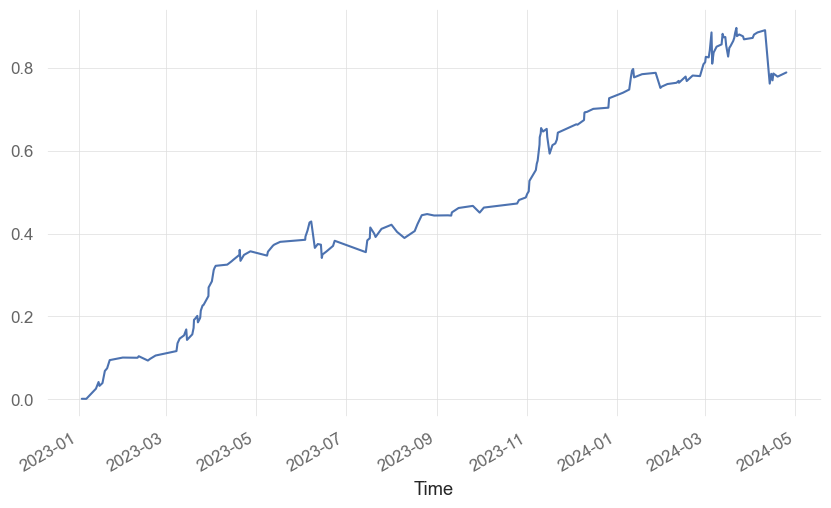

In [62]:
selected = Y_test.ret[y_proba_test>0.5]
selected.cumsum().plot()
print(selected.shape)

                           Strategy
-------------------------  ----------
Start Period               2023-01-02
End Period                 2024-04-28
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          85.81%
CAGR﹪                     38.25%

Sharpe                     1.41
Prob. Sharpe Ratio         95.1%
Smart Sharpe               1.36
Sortino                    1.67
Smart Sortino              1.62
Sortino/√2                 1.18
Smart Sortino/√2           1.14
Omega                      1.33

Max Drawdown               -21.7%
Longest DD Days            111
Volatility (ann.)          26.57%
Calmar                     1.76
Skew                       -3.32
Kurtosis                   19.46

Expected Daily %           0.13%
Expected Monthly %         3.95%
Expected Yearly %          36.31%
Kelly Criterion            17.53%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.6%
Expected Shortfall (cVaR)  -2.6%

Max Consecutive Wins      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-04-11,2024-04-13,2024-04-28,18,-21.699014,-21.076913
2,2023-07-20,2023-09-11,2023-11-07,111,-19.134369,-17.693128
3,2023-04-17,2023-05-08,2023-06-07,52,-12.186440,-11.355395
4,2023-06-10,2023-06-20,2023-07-17,38,-9.386689,-8.839492
5,2024-01-18,2024-01-30,2024-02-22,36,-9.169150,-8.882418


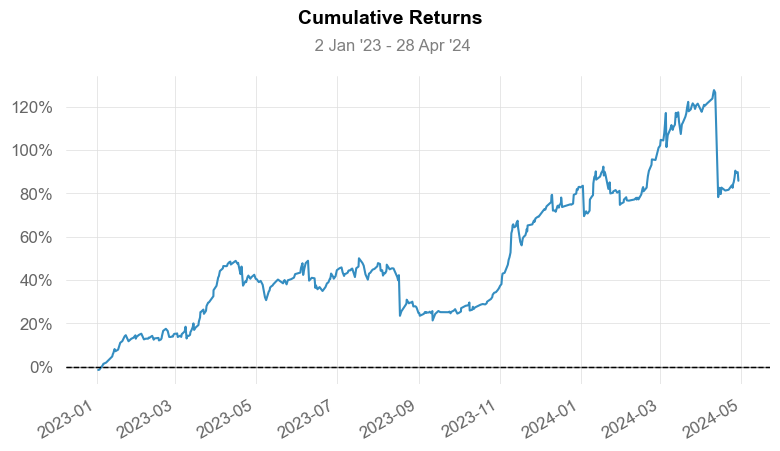

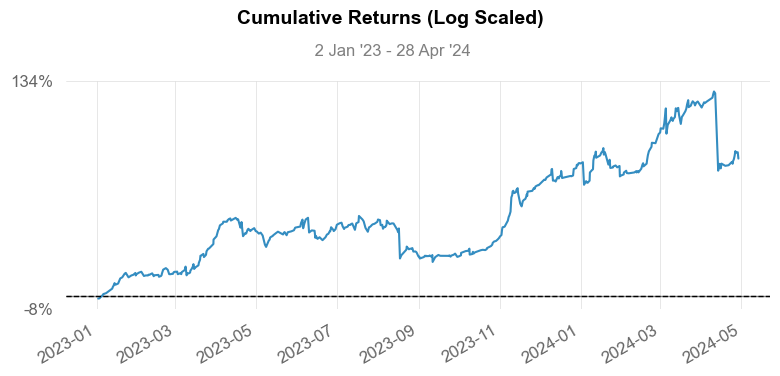

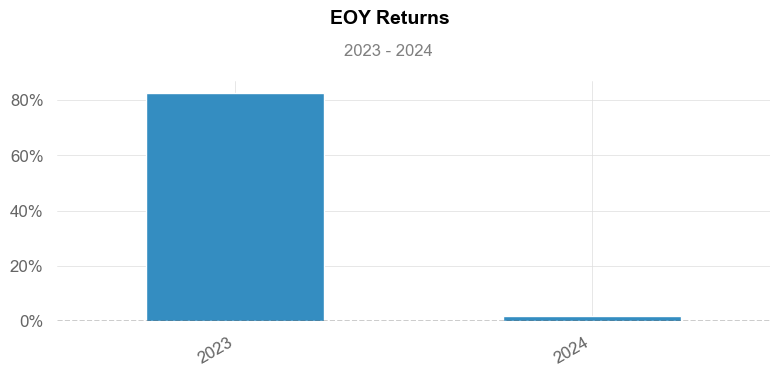

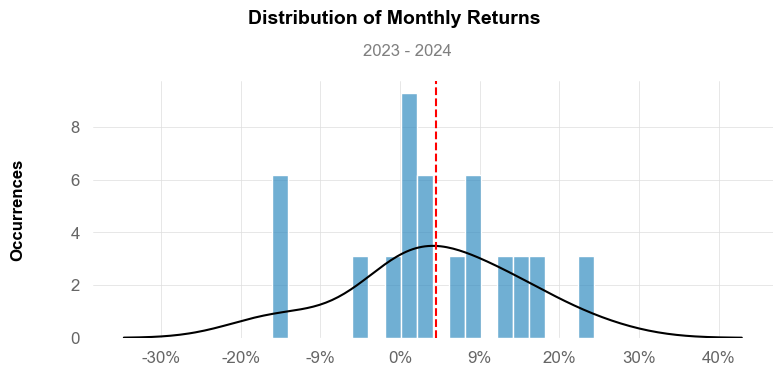

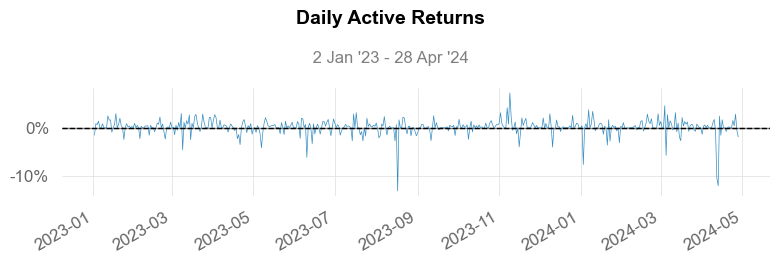

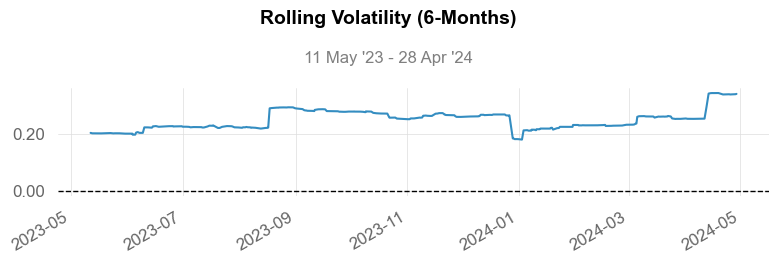

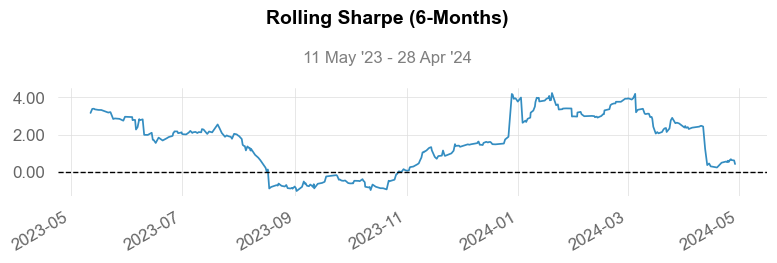

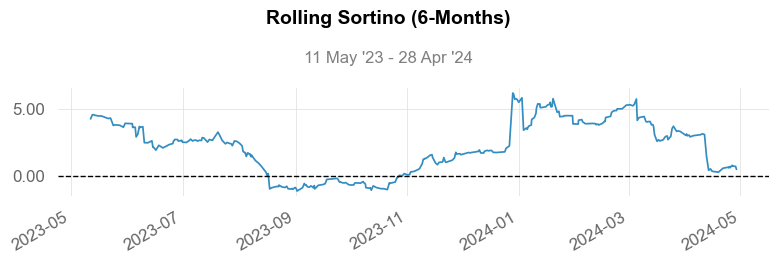

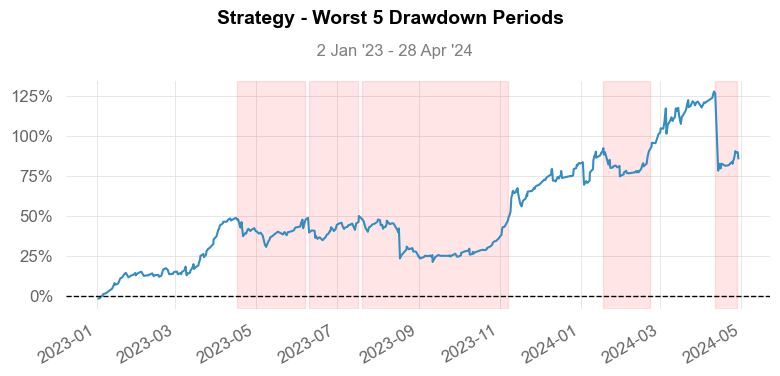

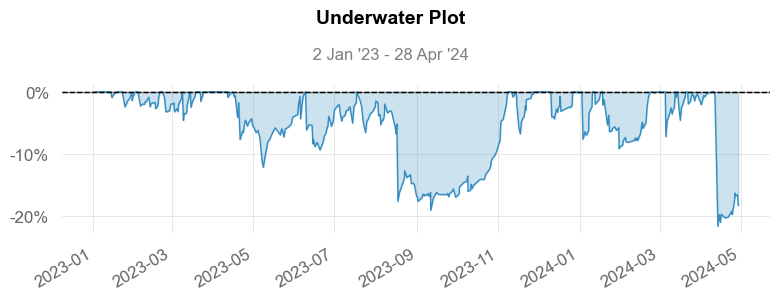

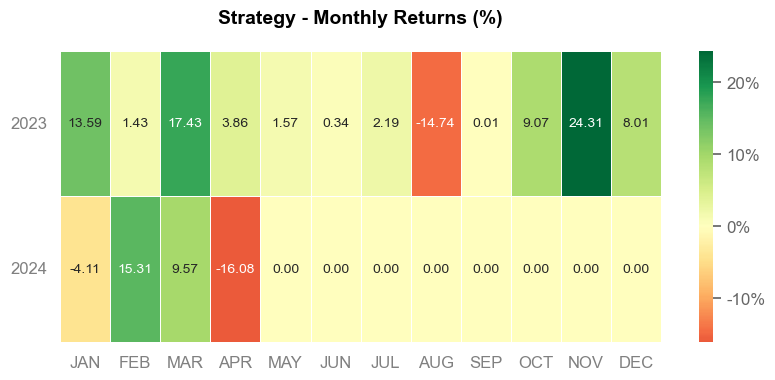

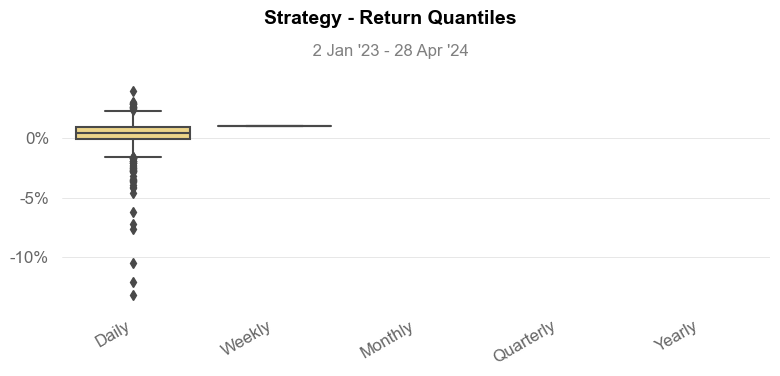

In [71]:
import quantstats as qs
qs.reports.full(np.exp(Y_test.ret)-1)

                           Strategy
-------------------------  ----------
Start Period               2023-01-03
End Period                 2024-04-25
Risk-Free Rate             0.0%
Time in Market             21.0%

Cumulative Return          87.47%
CAGR﹪                     39.28%

Sharpe                     2.15
Prob. Sharpe Ratio         98.92%
Smart Sharpe               1.91
Sortino                    3.06
Smart Sortino              2.73
Sortino/√2                 2.17
Smart Sortino/√2           1.93
Omega                      2.38

Max Drawdown               -12.09%
Longest DD Days            63
Volatility (ann.)          16.03%
Calmar                     3.25
Skew                       -3.13
Kurtosis                   51.26

Expected Daily %           0.13%
Expected Monthly %         4.01%
Expected Yearly %          36.92%
Kelly Criterion            43.98%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.52%
Expected Shortfall (cVaR)  -1.52%

Max Consecutive Wins    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-04-13,2024-04-13,2024-04-25,13,-12.086557,-11.388085
2,2024-03-05,2024-03-05,2024-03-11,7,-5.863687,-3.311037
3,2023-04-20,2023-04-21,2023-06-05,47,-4.904697,-3.693375
4,2024-03-15,2024-03-16,2024-03-20,6,-4.602806,-2.568658
5,2023-06-14,2023-07-14,2023-07-16,33,-3.853888,-3.295292


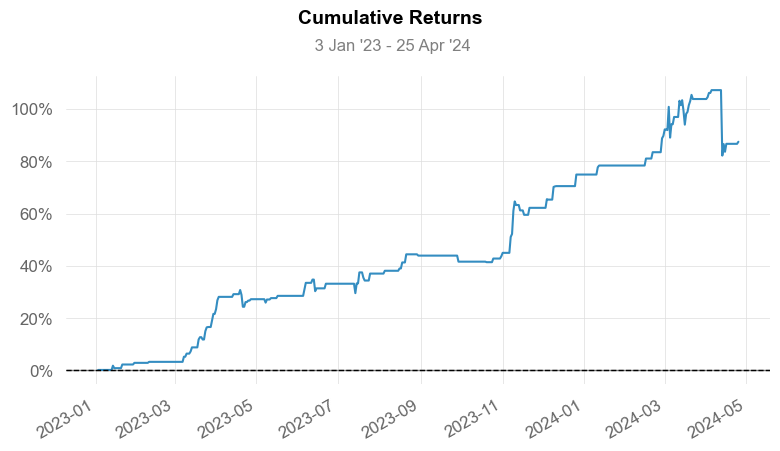

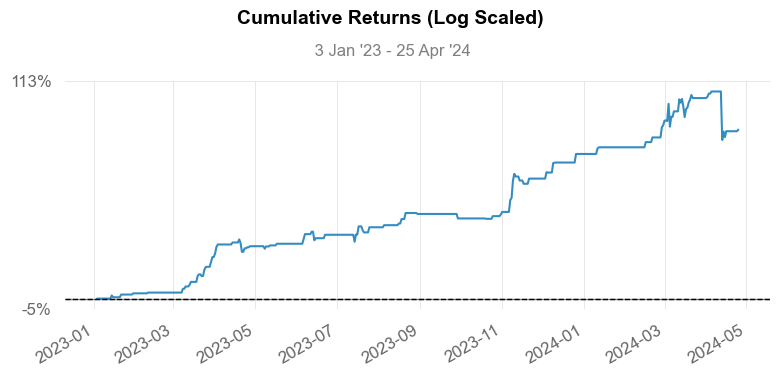

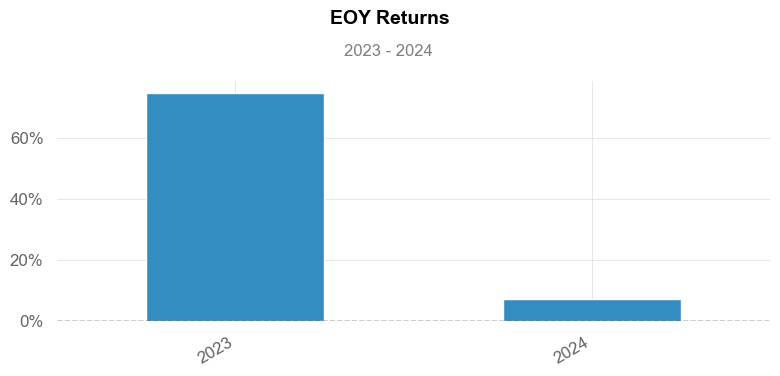

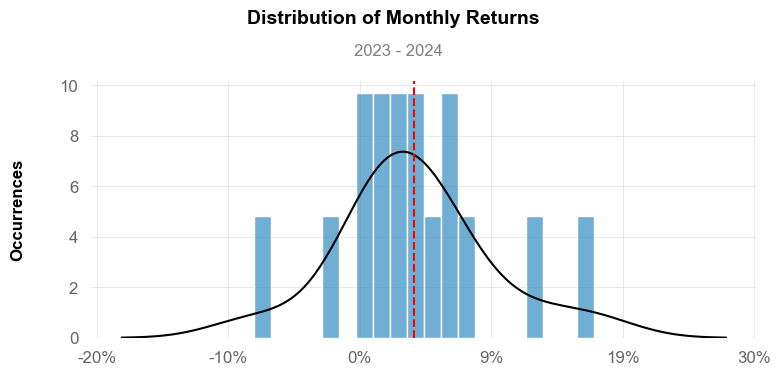

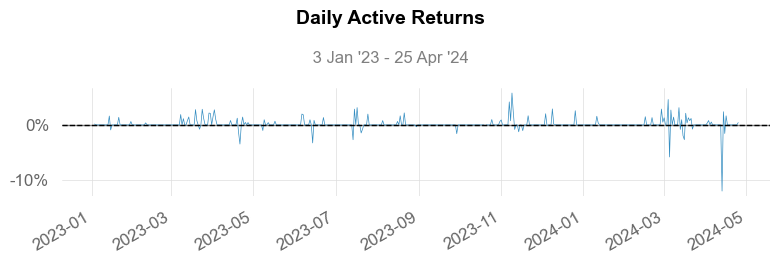

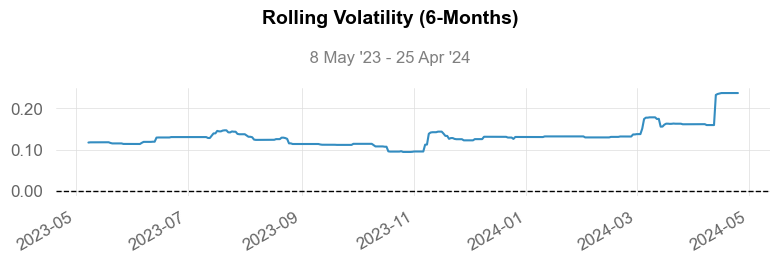

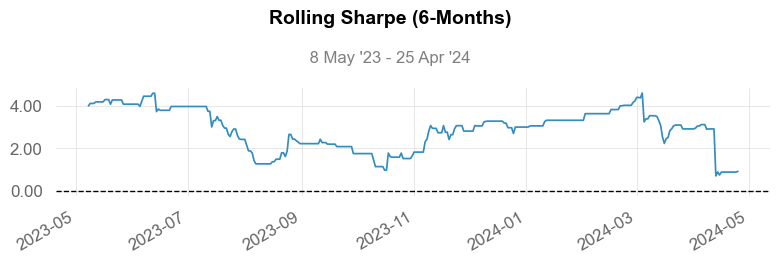

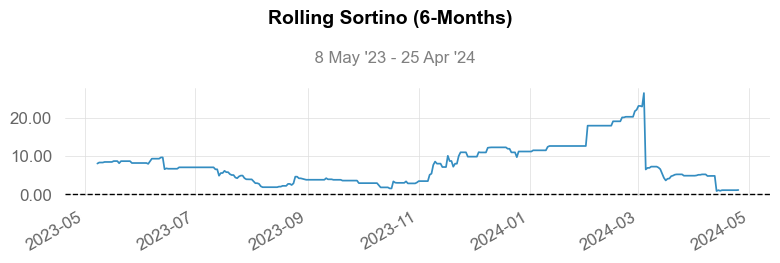

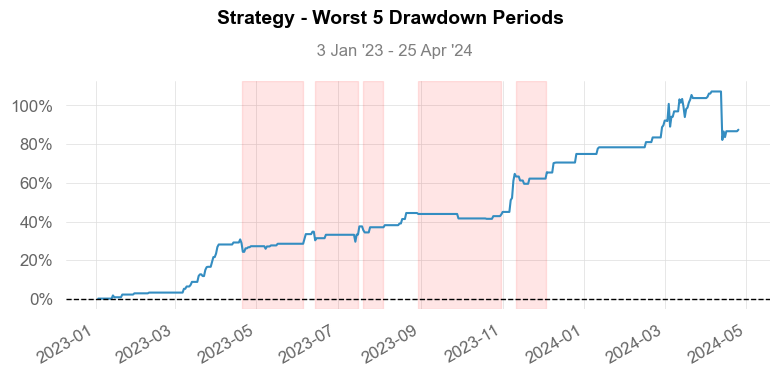

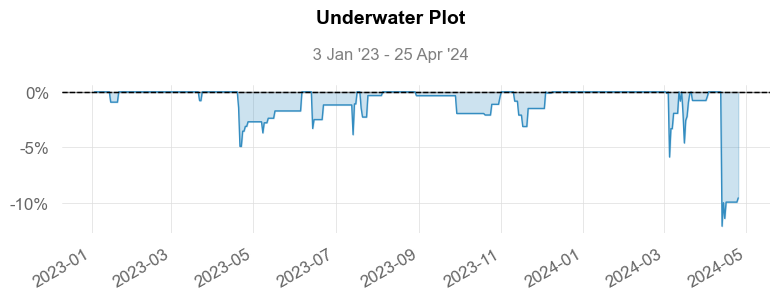

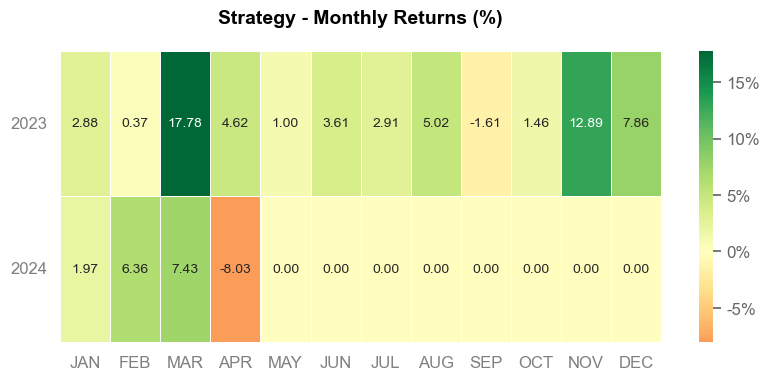

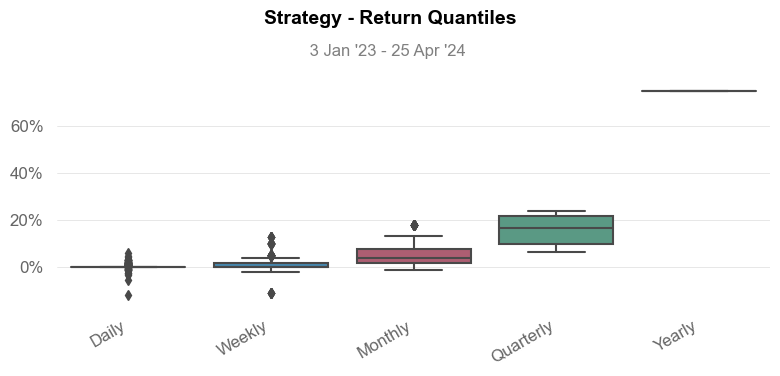

In [21]:
import quantstats as qs 
qs.reports.full(np.exp(selected.resample('1D').sum())-1)

                           Strategy
-------------------------  ----------
Start Period               2023-01-03
End Period                 2024-04-24
Risk-Free Rate             0.0%
Time in Market             32.0%

Cumulative Return          119.98%
CAGR﹪                     51.66%

Sharpe                     2.39
Prob. Sharpe Ratio         99.56%
Smart Sharpe               2.2
Sortino                    3.38
Smart Sortino              3.12
Sortino/√2                 2.39
Smart Sortino/√2           2.2
Omega                      2.2

Max Drawdown               -12.09%
Longest DD Days            72
Volatility (ann.)          18.14%
Calmar                     4.27
Skew                       -2.57
Kurtosis                   33.42

Expected Daily %           0.17%
Expected Monthly %         5.05%
Expected Yearly %          48.32%
Kelly Criterion            40.66%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.71%
Expected Shortfall (cVaR)  -1.71%

Max Consecutive Wins      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-04-13,2024-04-13,2024-04-24,12,-12.086557,-11.388085
2,2023-06-10,2023-06-14,2023-08-20,72,-8.415669,-7.654765
3,2023-11-11,2023-11-16,2023-12-03,23,-5.983754,-4.040512
4,2024-03-05,2024-03-05,2024-03-11,7,-5.863687,-3.311037
5,2024-03-13,2024-03-16,2024-03-20,8,-5.340082,-3.321656


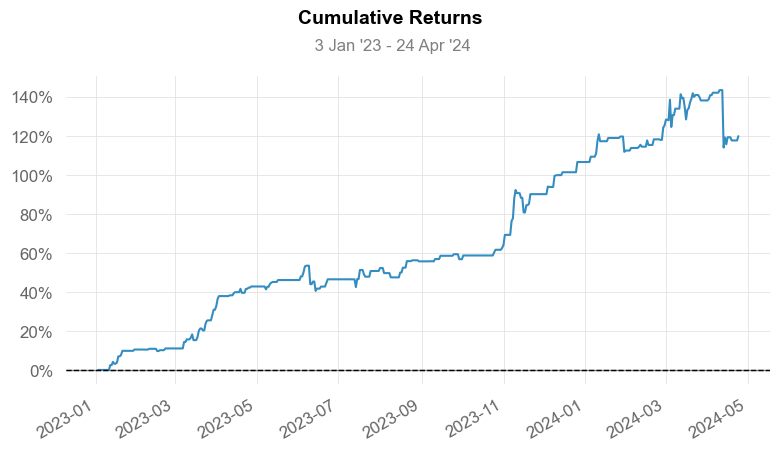

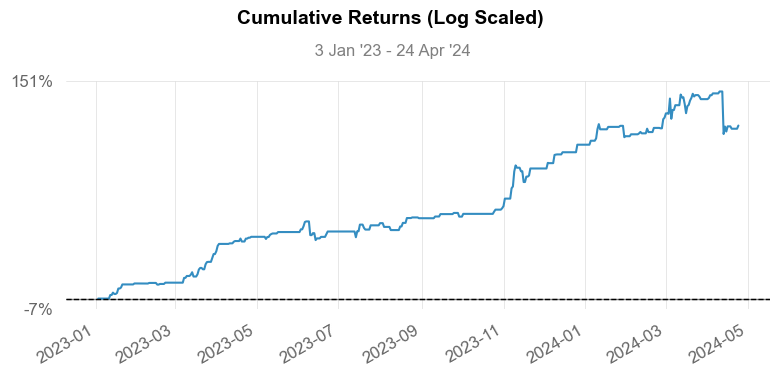

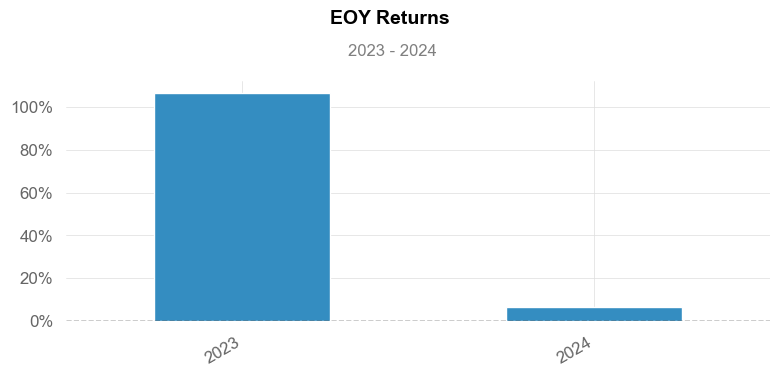

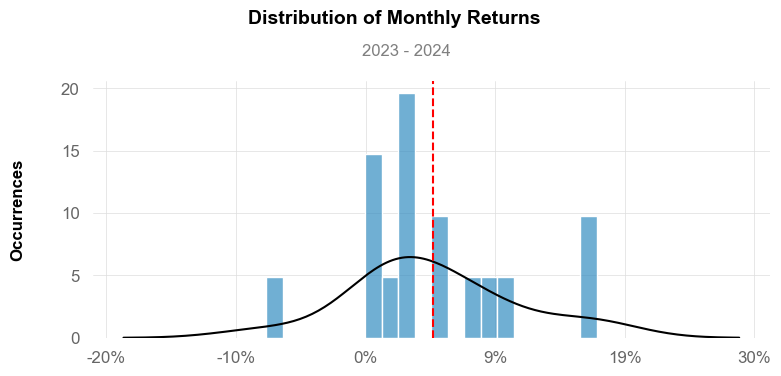

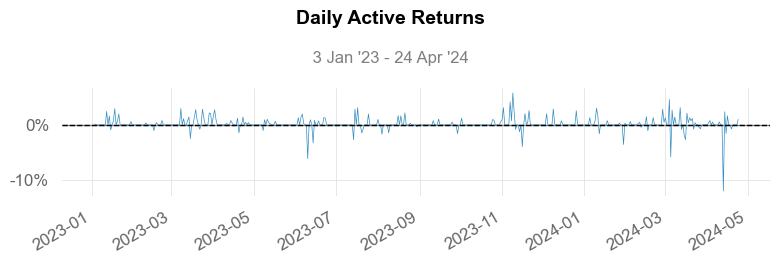

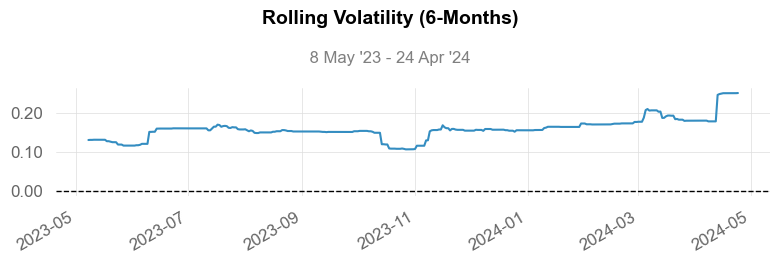

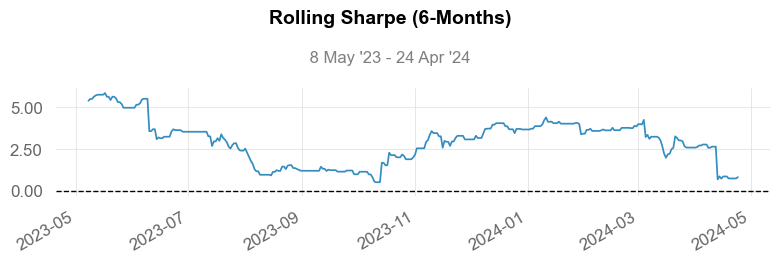

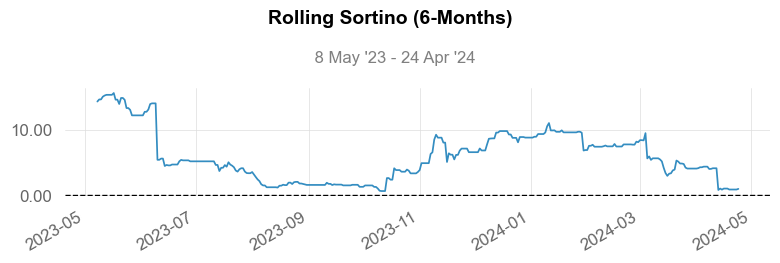

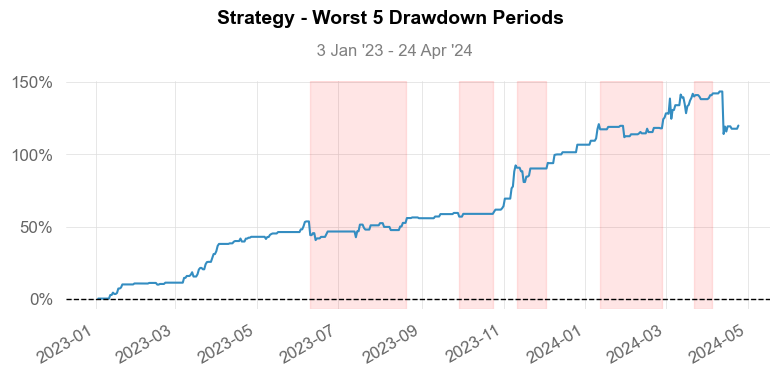

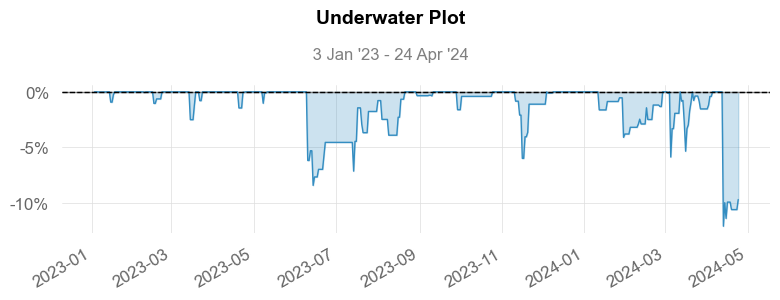

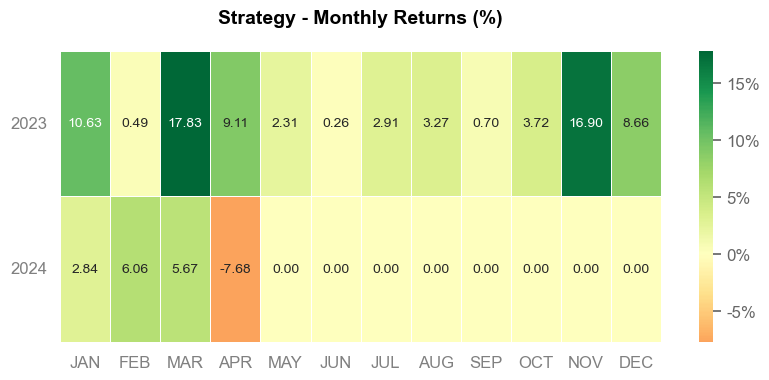

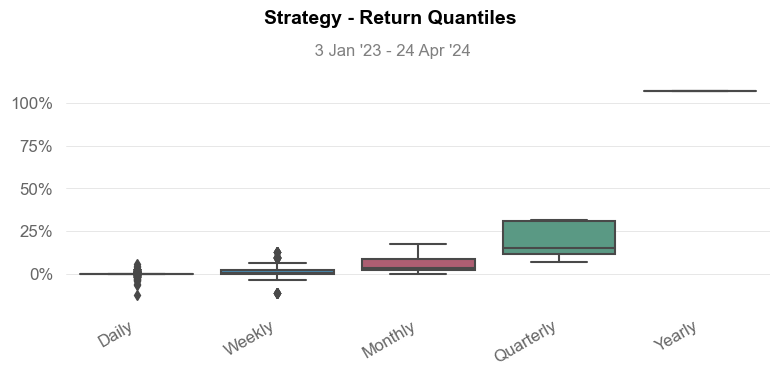

In [63]:
import quantstats as qs 
qs.reports.full(np.exp(selected.resample('1D').sum())-1)